In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import deque
from functools import partial
from path_search_visualization import animate_search

%matplotlib widget

In [2]:
DEFAULT_COLOR = "#0064e1"

def graph_factory():

    node_positions = {
        "S": (0, 0),
        "A": (0, 2),
        "B": (1, 1),
        "C": (2, 3),
        "D": (3, 1),
        "E": (3, 2),
        "G": (4, 3),
    }

    node_colors = {node: DEFAULT_COLOR for node in node_positions.keys()}

    node_attrs = {"positions": node_positions, "colors": node_colors}

    G = nx.Graph()

    G.add_weighted_edges_from(
        [
            ("S", "A", 2),
            ("S", "B", 4),
            ("A", "C", 2),
            ("B", "C", 1),
            ("C", "E", 4),
            ("B", "D", 1),
            ("D", "E", 2),
            ("E", "G", 5)
        ]
        )

    return G, node_attrs

## Graph traversal Algorithms

### Uninformed search
#### DFS and BFS

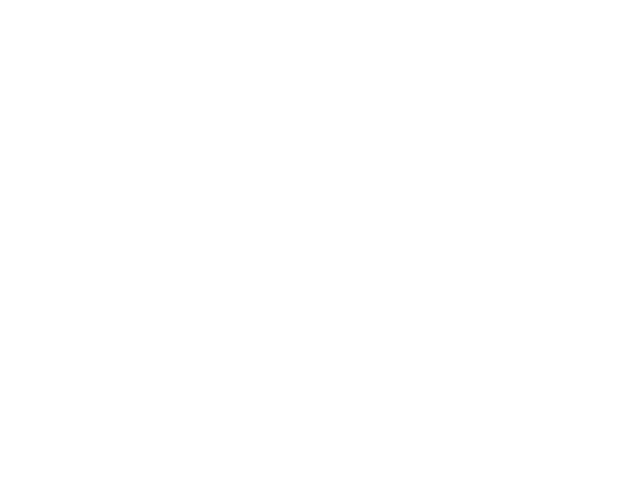

In [3]:
def dfs(G, start, end):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node])):
            if neighbor not in visited:
                q.appendleft(path + [neighbor])

    return []


G, node_attrs = graph_factory()

fig, ax = plt.subplots()
ax.axis("off")
explored_paths = dfs(G, "S", "G")
    
ani = animate_search(fig, ax, G, node_attrs["positions"], explored_paths)
plt.show()

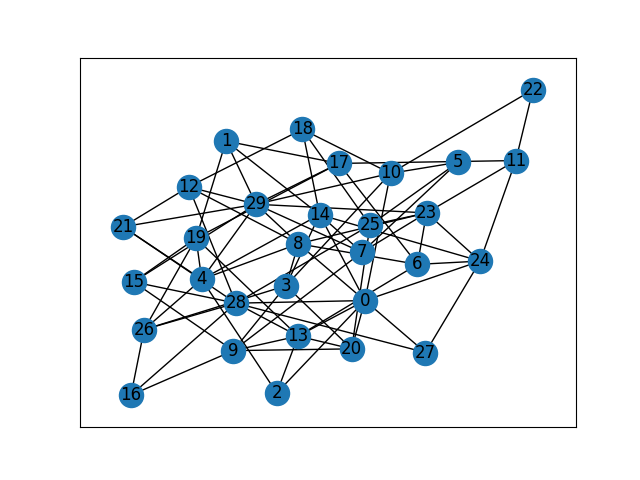

In [44]:
G = nx.erdos_renyi_graph(30, 0.2, seed=42)
positions = nx.spring_layout(G)
ax.axis("off")
fig, ax = plt.subplots()
nx.draw_networkx(G, pos=positions, ax=ax)
plt.show()

In [45]:
explored_paths = dfs(G, 3, 22)

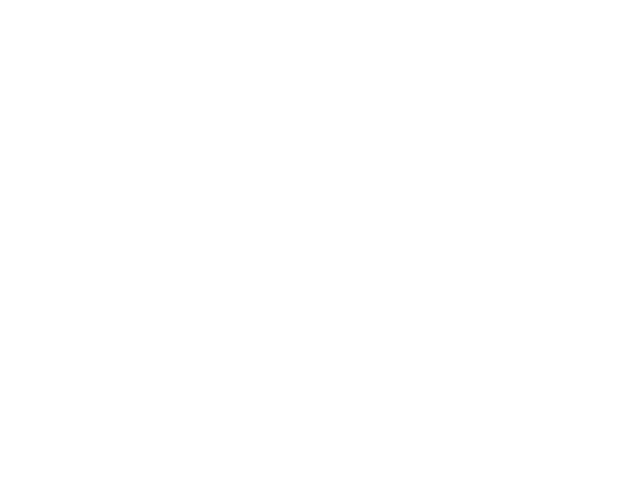

In [78]:
fig, ax = plt.subplots()
ax.axis("off")   
ani = animate_search(fig, ax, G, positions, explored_paths, interval=1000)
plt.show()

In [47]:
def bfs(G, start, end):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node])):
            if neighbor not in visited:
                q.append(path + [neighbor])

    return []

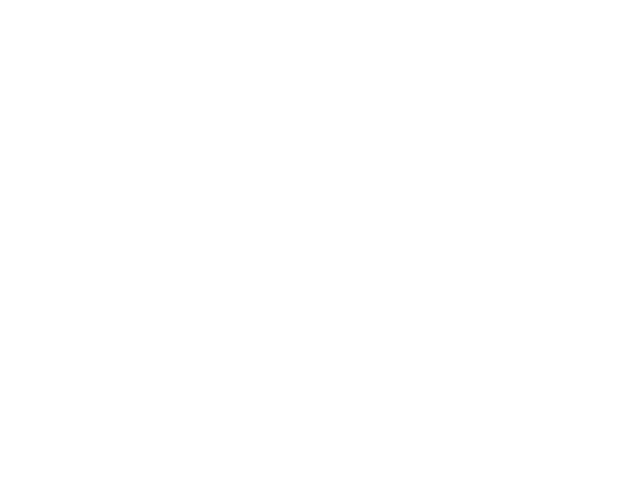

In [49]:
explored_paths = bfs(G, 3, 22)


fig, ax = plt.subplots()
ax.axis("off")   
ani = animate_search(fig, ax, G, positions, explored_paths, interval=1000)
plt.show()

## Using Heuristics

### Hill Climbing
Sort the optimal next nodes by their cartesian distance to the end goal. as-crow-flies / straight line distance heuristic

In [50]:
def cartesian_distance(node_positions, end, node):
    node_end_vector  = node_positions[end] - node_positions[node]
    return np.sqrt((node_end_vector * node_end_vector).sum())
    

def hill_climbing(G, start, end, heuristic):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node]), key=partial(heuristic, end), reverse=True):
            if neighbor not in visited:
                q.appendleft(path + [neighbor])

    return []

In [79]:
start, end = 16, 22
explored_paths_dfs = dfs(G, start, end)
explored_paths_hill_climbing = hill_climbing(G, start, end, partial(cartesian_distance, positions))

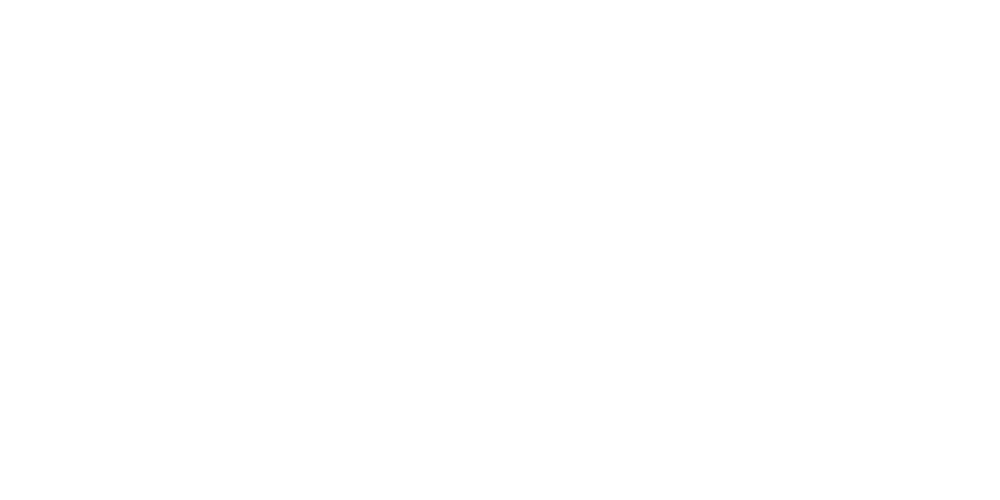

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.axis("off") 
ani_dfs = animate_search(fig, ax1, G, positions, explored_paths_dfs, interval=500)

ax2.axis("off") 
ani_hill = animate_search(fig, ax2, G, positions, explored_paths_hill_climbing, interval=1000)

plt.tight_layout()
plt.show()

### Beam Search
Follow the breadth first search level by level exploration but expands only the `w` best nodes and purges the rest.


In [71]:
def beam_search(G, start, end, heuristic, w):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        beam_ind = 0
        for neighbor in sorted(list(G.adj[last_node]), key=partial(heuristic, end)):
            if not (beam_ind < w):
                continue
            if neighbor not in visited:
                q.append(path + [neighbor])
            beam_ind += 1
            

    return []

In [81]:
start, end = 16, 22
explored_paths_bfs = bfs(G, start, end)
explored_paths_beam_search = beam_search(G, start, end, partial(cartesian_distance, positions), 2)

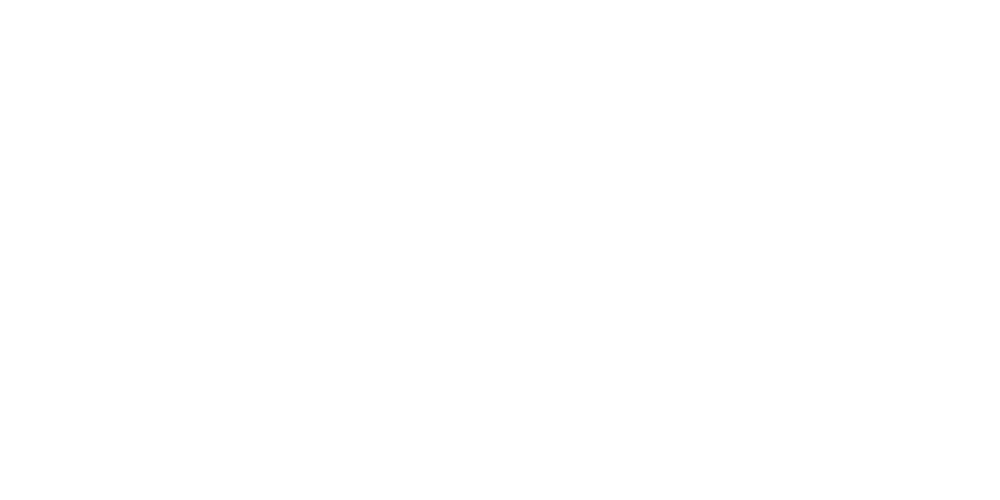

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.axis("off") 
ani_bfs = animate_search(fig, ax1, G, positions, explored_paths_bfs, interval=200)

ax2.axis("off") 
ani_beam = animate_search(fig, ax2, G, positions, explored_paths_beam_search, interval=200)

plt.tight_layout()
plt.show()

## Finding a path vs finding the optimal path

Until now dfs, bfs and their informed search adapted version content with finding one path between `start` and `end` but although for certain problems that might be usefull we can find ourselves wanting to compute the best possible path that solves the problem. We'll be concern about the `length` of the paths we find.

In [93]:
def path_length(G, path):
    edges_list = [(a, b) for a, b in zip(path[:-1], path[1:])]
    print([G.edges[edge] for edge in edges_list], sep="\n")

path_length(G, explored_paths_beam_search[-1])

[{}, {}, {}, {}]
